In [1]:
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH15-Agents")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH15-Agents


In [2]:
from langchain.tools import tool
from typing import List, Dict, Annotated
from langchain_teddynote.tools import GoogleNews
from langchain_experimental.utilities import PythonREPL

# 도구 생성
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)

# 도구 생성
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    result = ""
    try:
        result = PythonREPL().run(code)
    except BaseException as e:
        print(f"Failed to execute. Error: {repr(e)}")
    finally:
        return result


print(f"도구 이름: {search_news.name}")
print(f"도구 설명: {search_news.description}")
print(f"도구 이름: {python_repl_tool.name}")
print(f"도구 설명: {python_repl_tool.description}")

도구 이름: search_news
도구 설명: Search Google News by input keyword
도구 이름: python_repl_tool
도구 설명: Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.


In [3]:
# tools 정의
tools = [search_news, python_repl_tool]

# Agent 프롬프트 생성

In [4]:
from langchain_core.prompts import ChatPromptTemplate

# 프롬프트 생성
# 프롬프트는 에이전트에게 모델이 수행할 작업을 설명하는 텍스트를 제공 (도구의 이름과 역할을 입력)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant. Make sure to use the `search_news` tool for searching ketword related news."),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}")
    ]
)

# Agent 생성

In [5]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent

# LLM 정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Agent 정의
agent = create_tool_calling_agent(llm, tools, prompt)

# AgentExecutor

In [6]:
from langchain.agents import AgentExecutor

# AgentExecutor 생성
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    max_iterations=10,
    max_execution_time=10,
    handle_parsing_errors=True,
)

# AgentExecutor 실행
result = agent_executor.invoke({"input": "AI 투자와 관련된 뉴스를 검색해 주세요."})

print("Agent 실행 결과:")
print(result['output'])



> Entering new AgentExecutor chain...

Invoking: `search_news` with `{'query': 'AI 투자'}`


[{'url': 'https://news.google.com/rss/articles/CBMiWkFVX3lxTE1MckRhRy1VdDdHMXhBYUhIQWJrYXhGR2IyckFKUGhLSTlneFZCNnRPZlJCbjlDNDZCbGZjZW00cXE1VEN0M19TUDdQY0owVTRUeFp3bHhMRnp1QdIBVEFVX3lxTE1fLTI5bUVQdk5NZTZmWEkyRUhuM1RTWHJzSUZqQkNDSmNKSVlSUnNIT0FSanN3X2xOa25iYmRPakE3amVfd1hDOHZxSnZBVmswTTZKbA?oc=5', 'content': '퓨리오사AI 투자 대박…TS·DSC인베스트 급등 - 한국경제'}, {'url': 'https://news.google.com/rss/articles/CBMiZkFVX3lxTE9HWEhnTHFRV3V1Tnlza1dGay1PeGdGdkhXQ3hwNHBMWEt4Y3MzYS1fdkZsQWZZVlhwWFZmeHlaWkhRSklsXzlRdTg3Rk9zaHh4MVltazY5QkRpQktUUEc4eGdESGo2Z9IBbkFVX3lxTFA0Um1fM3RQbVpGWGxIQy1yQmlxSkd4dkp4OW4wNDNPaWlzTVV1blRvVzh2cklucnpkalBpeUNnUlkzMzRVbDA0MFFudHM4Tzhvc3R5QTk4VnlYb1RXT0kxUWVFUllSTE4wdVVRLXBB?oc=5', 'content': '이재명이 만난 퓨리오사AI에 투자금 쏠리자 창업투자株 급등 - 머니투데이'}, {'url': 'https://news.google.com/rss/articles/CBMiWkFVX3lxTE9rbUNLdjJsMGZSYUNxSE1xNDhwTGRZNlAtaks3TVQ2ekZNc3RrZU9uWUVURWxqZDE0bzgwbmV5Q1FvaUN1M1pIdEpXZHJZSWlEd

# Stream 출력으로 단계별 결과 확인

In [7]:
from langchain.agents import AgentExecutor

# AgentExecutor 생성
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=False,
    handle_parsing_errors=True,
)

In [8]:
# 스트리밍 모드 실행
result = agent_executor.stream({"input": "AI 투자와 관련된 뉴스를 검색해 주세요."})

for step in result:
    # 중간 단계 출력
    print(step)

{'actions': [ToolAgentAction(tool='search_news', tool_input={'query': 'AI 투자'}, log="\nInvoking: `search_news` with `{'query': 'AI 투자'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_XUzYwtHEln7P0zb4kWR3oZeX', 'function': {'arguments': '{"query":"AI 투자"}', 'name': 'search_news'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090'}, id='run-39c98279-cbaf-4b62-97fa-3b8aede6aa2c', tool_calls=[{'name': 'search_news', 'args': {'query': 'AI 투자'}, 'id': 'call_XUzYwtHEln7P0zb4kWR3oZeX', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'search_news', 'args': '{"query":"AI 투자"}', 'id': 'call_XUzYwtHEln7P0zb4kWR3oZeX', 'index': 0, 'type': 'tool_call_chunk'}])], tool_call_id='call_XUzYwtHEln7P0zb4kWR3oZeX')], 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_XUzYwtHEln7P0zb4kWR3oZeX', 'func

In [9]:
from langchain_teddynote.messages import AgentStreamParser

agent_stream_parser = AgentStreamParser()

Python REPL can execute arbitrary code. Use with caution.


[도구 호출]
Tool: python_repl_tool
code: import matplotlib.pyplot as plt

# 데이터
sizes = [15, 30, 45, 10]
labels = ['A', 'B', 'C', 'D']
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

# 파이 차트 그리기
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sample Pie Chart')
plt.show()
Log: 
Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as plt\n\n# 데이터\nsizes = [15, 30, 45, 10]\nlabels = ['A', 'B', 'C', 'D']\ncolors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']\n\n# 파이 차트 그리기\nplt.figure(figsize=(8, 6))\nplt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)\nplt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.\nplt.title('Sample Pie Chart')\nplt.show()"}`





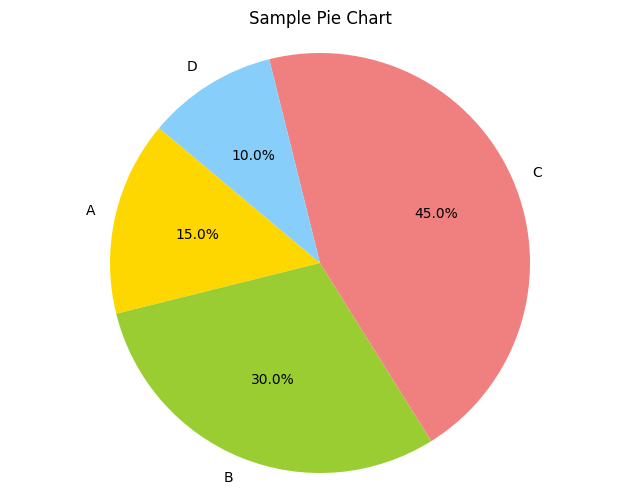

[관찰 내용]
Observation: 
[최종 답변]
파이 차트가 성공적으로 그려졌습니다. 차트는 각 섹션의 비율을 보여주며, 레이블과 색상이 포함되어 있습니다. 차트의 제목은 "Sample Pie Chart"입니다. 

이제 차트를 확인해 보세요!


In [10]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream(
    {"input": "matplotlib 을 사용하여 pie 차트를 그리는 코드를 작성하고 실행하세요."}
)

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    agent_stream_parser.process_agent_steps(step)

In [11]:
# AgentCallbacks와 AgentStreamParser를 langchain_teddynote.messages에서 가져옵니다.
from langchain_teddynote.messages import AgentCallbacks, AgentStreamParser


# 도구 호출 시 실행되는 콜백 함수입니다.
def tool_callback(tool) -> None:
    print("<<<<<<< 도구 호출 >>>>>>")
    print(f"Tool: {tool.get('tool')}")  # 사용된 도구의 이름을 출력합니다.
    print("<<<<<<< 도구 호출 >>>>>>")


# 관찰 결과를 출력하는 콜백 함수입니다.
def observation_callback(observation) -> None:
    print("<<<<<<< 관찰 내용 >>>>>>")
    print(
        f"Observation: {observation.get('observation')[0]}"
    )  # 관찰 내용을 출력합니다.
    print("<<<<<<< 관찰 내용 >>>>>>")


# 최종 결과를 출력하는 콜백 함수입니다.
def result_callback(result: str) -> None:
    print("<<<<<<< 최종 답변 >>>>>>")
    print(result)  # 최종 답변을 출력합니다.
    print("<<<<<<< 최종 답변 >>>>>>")


# AgentCallbacks 객체를 생성하여 각 단계별 콜백 함수를 설정합니다.
agent_callbacks = AgentCallbacks(
    tool_callback=tool_callback,
    observation_callback=observation_callback,
    result_callback=result_callback,
)

# AgentStreamParser 객체를 생성하여 에이전트의 실행 과정을 파싱합니다.
agent_stream_parser = AgentStreamParser(agent_callbacks)

In [12]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream({"input": "AI 투자관련 뉴스를 검색해 주세요."})

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 도구 호출 >>>>>>
Tool: search_news
<<<<<<< 도구 호출 >>>>>>
<<<<<<< 관찰 내용 >>>>>>
Observation: {'url': 'https://news.google.com/rss/articles/CBMiWkFVX3lxTE1MckRhRy1VdDdHMXhBYUhIQWJrYXhGR2IyckFKUGhLSTlneFZCNnRPZlJCbjlDNDZCbGZjZW00cXE1VEN0M19TUDdQY0owVTRUeFp3bHhMRnp1QdIBVEFVX3lxTE1fLTI5bUVQdk5NZTZmWEkyRUhuM1RTWHJzSUZqQkNDSmNKSVlSUnNIT0FSanN3X2xOa25iYmRPakE3amVfd1hDOHZxSnZBVmswTTZKbA?oc=5', 'content': '퓨리오사AI 투자 대박…TS·DSC인베스트 급등 - 한국경제'}
<<<<<<< 관찰 내용 >>>>>>
<<<<<<< 최종 답변 >>>>>>
다음은 AI 투자와 관련된 최근 뉴스 기사들입니다:

1. [퓨리오사AI 투자 대박…TS·DSC인베스트 급등 - 한국경제](https://news.google.com/rss/articles/CBMiWkFVX3lxTE1MckRhRy1VdDdHMXhBYUhIQWJrYXhGR2IyckFKUGhLSTlneFZCNnRPZlJCbjlDNDZCbGZjZW00cXE1VEN0M19TUDdQY0owVTRUeFp3bHhMRnp1QdIBVEFVX3lxTE1fLTI5bUVQdk5NZTZmWEkyRUhuM1RTWHJzSUZqQkNDSmNKSVlSUnNIT0FSanN3X2xOa25iYmRPakE3amVfd1hDOHZxSnZBVmswTTZKbA)

2. [이재명이 만난 퓨리오사AI에 투자금 쏠리자 창업투자株 급등 - 머니투데이](https://news.google.com/rss/articles/CBMiZkFVX3lxTE9HWEhnTHFRV3V1Tnlza1dGay1PeGdGdkhXQ3hwNHBMWEt4Y3MzYS1fdkZsQWZZVlhwWFZmeH

# 이전 대화내용 기억하는 Agent

In [13]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory


# session_id를 저장할 딕셔너리 생성
store = {}

# session_id를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store:
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]

# 채팅 메시지 기록이 추가된 에이전트를 생성
agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
)

In [14]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {"input": "안녕? 내 이름은 종진이야."},
    config={"configurable": {"session_id": "abc123"}}
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 최종 답변 >>>>>>
안녕하세요, 종진님! 어떻게 도와드릴까요?
<<<<<<< 최종 답변 >>>>>>


In [15]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {"input": "내 이름이 뭐라고?"},
    # session_id 설정
    config={"configurable": {"session_id": "abc123"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 최종 답변 >>>>>>
종진님이라고 하셨습니다! 맞나요?
<<<<<<< 최종 답변 >>>>>>


In [16]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {
        "input": "내 이메일 주소는 teddy@teddynote.com 이야. 회사 이름은 테디노트 주식회사야."
    },
    # session_id 설정
    config={"configurable": {"session_id": "abc123"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 최종 답변 >>>>>>
감사합니다, 종진님! 테디노트 주식회사에 대해 궁금한 점이 있으신가요? 아니면 다른 도움이 필요하신가요?
<<<<<<< 최종 답변 >>>>>>


In [17]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {
        "input": "최신 뉴스 5개를 검색해서 이메일의 본문으로 작성해줘. "
        "수신인에는 `셜리 상무님` 그리고, 발신인에는 내 인적정보를 적어줘."
        "정중한 어조로 작성하고, 메일의 시작과 끝에는 적절한 인사말과 맺음말을 적어줘."
    },
    # session_id 설정
    config={"configurable": {"session_id": "abc123"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 도구 호출 >>>>>>
Tool: search_news
<<<<<<< 도구 호출 >>>>>>
<<<<<<< 관찰 내용 >>>>>>
Observation: {'url': 'https://news.google.com/rss/articles/CBMiZEFVX3lxTE96MnluVWlyX25IX2tKV25hNmxYVVFyQ21vbEFzYXFLYzVDeTdTeTl2RkdDeV9rTnE4clBlMXNQTDBEbFpsUE1LVTlFWGJKM2Y2SEFxMDFqS3JBcGtqYVIyQWxPaUc?oc=5', 'content': '[신간]] 유튜버 테디노트와 AI 전문가의 챗GPT 업무 활용법 『일잘러의 비밀, 챗GPT와 GPTs로 나만의 AI 챗봇 만들기』 - 매일일보'}
<<<<<<< 관찰 내용 >>>>>>
<<<<<<< 최종 답변 >>>>>>
아래는 셜리 상무님께 보낼 이메일 초안입니다.

---

제목: 최신 뉴스 업데이트

안녕하세요, 셜리 상무님.

테디노트 주식회사에 관련된 최신 뉴스를 아래와 같이 공유드립니다.

1. [유튜버 테디노트와 AI 전문가의 챗GPT 업무 활용법 『일잘러의 비밀, 챗GPT와 GPTs로 나만의 AI 챗봇 만들기』 - 매일일보](https://news.google.com/rss/articles/CBMiZEFVX3lxTE96MnluVWlyX25IX2tKV25hNmxYVVFyQ21vbEFzYXFLYzVDeTdTeTl2RkdDeV9rTnE4clBlMXNQTDBEbFpsUE1LVTlFWGJKM2Y2SEFxMDFqS3JBcGtqYVIyQWxPaUc?oc=5)

2. [신간 '일잘러의 비밀, 챗GPT와 GPTs로 나만의 AI 챗봇 만들기' - 뉴스핌](https://news.google.com/rss/articles/CBMiXEFVX3lxTE9KWkJkQWRLRzFZNUxMR2N6d283dk81NDhtNUxpLU9pZ0pjMHQ3VmQyU3VrVTRLc1dYdFdIa1JtQ25fbkNKWnZhYXBIOHVLVExGVmdYY2FNM0VK